Импортируем необходимые библиотеки

In [19]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import statsmodels.tsa.api as smt

In [20]:
def generate_by_template(template, serise_count = 10, make_noise = True, ot = -5, to = 5, count = 100):
    offs = np.random.rand(serise_count)
    arr = np.linspace(ot, to, count)
    result = []
    for i in range(serise_count):
        if make_noise:
            result.append(template(arr+offs[i])+np.random.normal(size = 100, scale= 0.1))
        else:
            result.append(template(arr+offs[i]))
    return result

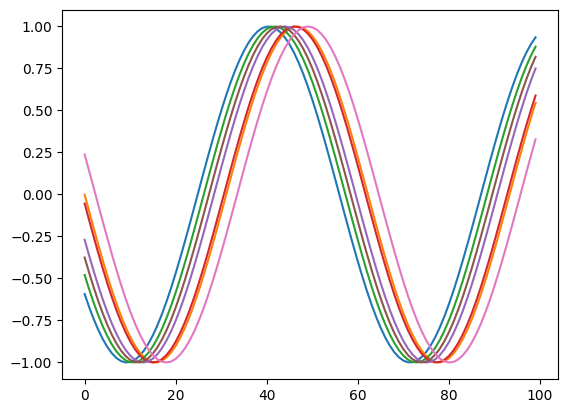

In [21]:
class1 = generate_by_template(np.cos, 7, False)
class2 = generate_by_template(np.sin, 7, False)
class3 = generate_by_template(np.tanh, 7, False)
for ts in class1:
    plt.plot(ts)

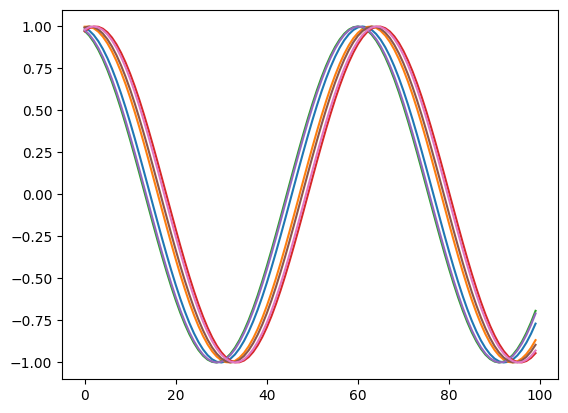

In [22]:
for ts in class2:
    plt.plot(ts)

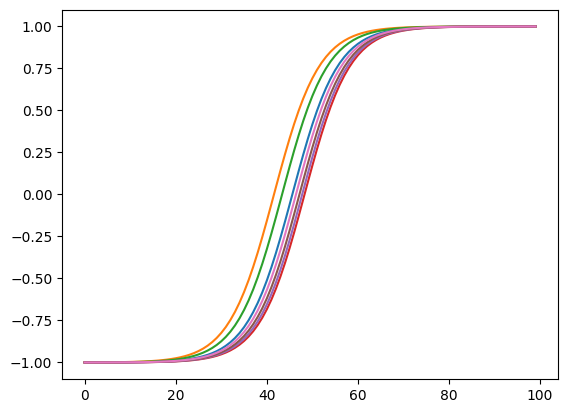

In [23]:
for ts in class3:
    plt.plot(ts)

## DTW

In [24]:
def distance_matrix(x, y, q) -> np.array:
    """
    Функция  рассчета  матрицы  расстояний между точками двух рядов 
    """
    mdist = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            mdist[i,j] = np.abs((x[j]-y[i]))**q
    return mdist

In [25]:
# Посчитаем DTW для двух временных рядов
# Сначала напишем функцию, которая это все вычисляет


def DTW(x, x_s, q=1, isDTW=True):
    '''
        x: первый ряд
        x_s : второй ряд
        q : степень для вычисления базового расстояния
    '''
    N = len(x) # Считаем, что ряды равной длины. Но это не всегда так, перепишите функцию для 
               # вычисления расстояния между рядами, длины которых не равны
    
    # Строим матрицу согласно реккурентной формуле, полученной выше. Матрица в нашем случае будет размерности 

    dist = distance_matrix(x,x_s,q=2)
    
    R = [[0] * (N+1) for i in range(N+1)]
   
    for i in range(1,N): 
        R[i][0] = dist[i,0] + R[i-1][0] 
        R[0][i] = dist[0,i] + R[0][i-1]

    k = 0
    if isDTW:
        k = 1
    
    # начинаем расчет по реккурентной формуле
  
    for i in range(1,N+1): 
        for j in range(1,N+1):
            R[i][j] = dist[i-1,j-1] + k*np.min([R[i-1][j-1], R[i][j-1], R[i-1][j]]) 

    # ищем минимальный путь. Начинаем от нижнего правого угла.
    pth = []   # лист с кортежами индексов пути
    i = N
    j = N
    while i >= 0 and j >= 0:
        pth.append((i,j))
        if R[i][j-1] <= R[i-1][j-1] and R[i][j-1] <= R[i-1][j]:
            I = i
            J = j-1                
        
        if R[i-1][j] <= R[i-1][j-1] and R[i-1][j] <= R[i][j-1]:
            I = i - 1
            J = j 

        if R[i-1][j-1] <= R[i][j-1] and R[i-1][j-1] <= R[i-1][j]:
            I = i - 1
            J = j - 1
        
        i = I
        j = J


    #Считаем расстояние между двумя рядами
    s = 0
    for l in pth:
        s += R[l[0]][l[1]]
    s = s/len(pth) 

    return s, pth, R


## Посчитаем DTW для некоторых сгенерированных рядов

In [26]:
x1 = np.abs(class1[0])
x2 = np.abs(class2[0])
x3 = np.abs(class3[0])
s12 = DTW(x1,x2,q=2)
s23 = DTW(x2,x3,q=2)
s13 = DTW(x1,x3,q =2)
print (f"DTW\nTs1 и Ts2 = {s12[0]}\nTs2 и Ts3 = {s23[0]}\nTs1 и Ts3 = {s13[0]}")

DTW
Ts1 и Ts2 = 0.2791377328914547
Ts2 и Ts3 = 2.7465337467389572
Ts1 и Ts3 = 3.3673464469708043


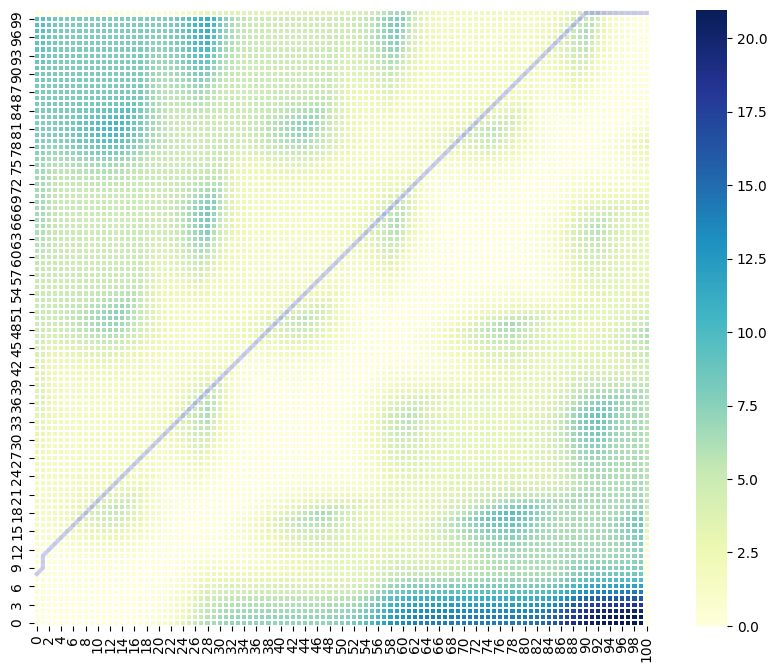

In [27]:
import seaborn as sbn
# Отрисуем матрицы весов расстояний Ts1 и Ts2

cost_matrix = s12[2]
warp_path = s12[1]

fig, ax = plt.subplots(figsize=(12, 8))
ax = sbn.heatmap(cost_matrix, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()


path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=3, alpha=0.2)

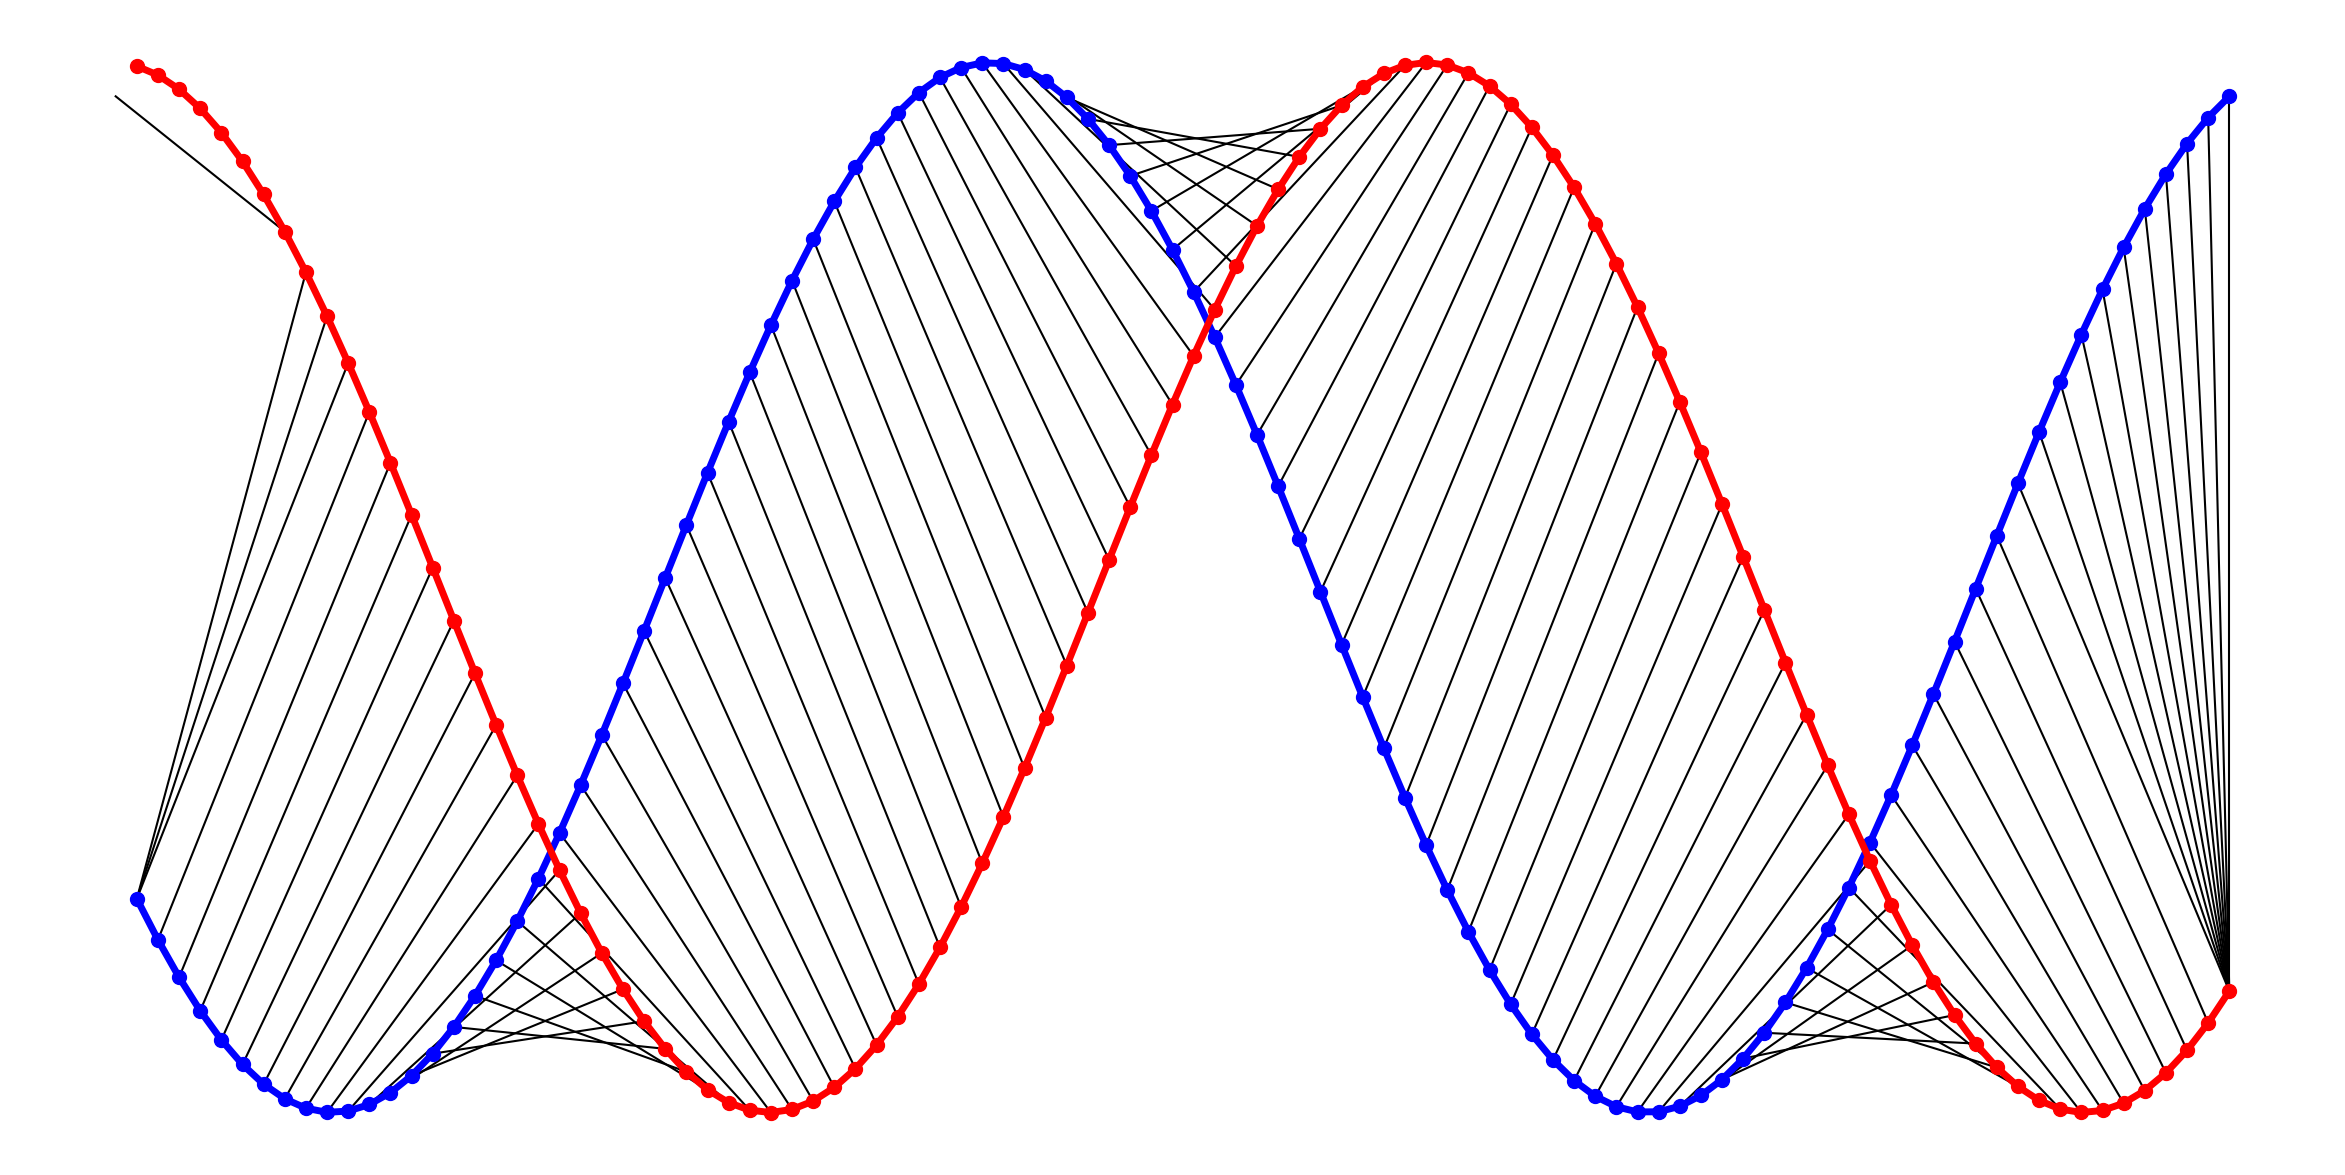

In [28]:
fig, ax = plt.subplots(figsize=(30, 15))


warp_path = s12[1]
x1 = class1[0]
x2 = class2[0]

# Remove the border and axes ticks
fig.patch.set_visible(True)
ax.axis('off')

for [map_x, map_y] in warp_path:   
    ax.set_facecolor('white')
    ax.plot([map_x-1, map_y-1], [x1[map_x-1], x2[map_y-1]], '-k')

ax.plot(x1, color='blue', marker='o', markersize=10, linewidth=5)
ax.plot(x2, color='red', marker='o', markersize=10, linewidth=5)
ax.tick_params(axis="both", which="major", labelsize=18)

DTW хорошо вычесляет расстояние между синусом и косинусом(даже со смещением)

In [29]:
#Сгенерируем из классов датасет
X = np.vstack((class1, class2, class3))
y = np.hstack((np.zeros(7), np.ones(7), np.ones(7) * 2))

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
def DTW_cut(X, x_s):
    return DTW(X, x_s)[0]

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

knn_dtw = KNeighborsClassifier(metric=DTW)
knn_euclidean =KNeighborsClassifier(metric='euclidean')
tsf = RandomForestClassifier(n_estimators=100, random_state=1)

In [46]:
knn_dtw.fit(X_train, y_train)
knn_euclidean.fit(X_train, y_train)
tsf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [44]:
X_train

array([[ 0.98082303,  0.99547705,  0.99998281, ..., -0.98436827,
        -0.96159086, -0.92901063],
       [ 0.23803947,  0.13888627,  0.03831722, ...,  0.13246455,
         0.23173916,  0.32865134],
       [-0.59289609, -0.67107705, -0.7424168 , ...,  0.84568762,
         0.89519227,  0.93557099],
       ...,
       [-0.99985432, -0.9998217 , -0.99978179, ...,  0.99991524,
         0.99993075,  0.99994341],
       [ 0.99367769,  0.9999339 ,  0.99599642, ..., -0.96621127,
        -0.93529507, -0.89484413],
       [ 0.97833833,  0.95247675,  0.91690528, ..., -0.8355177 ,
        -0.77585188, -0.70827673]])

In [45]:
X_test

array([[-0.05394079, -0.15435745, -0.25320054, -0.34946241, -0.44216174,
        -0.5303535 , -0.61313864, -0.68967322, -0.75917702, -0.82094149,
        -0.87433698, -0.91881916, -0.95393456, -0.97932519, -0.99473223,
        -0.99999859, -0.99507061, -0.9799985 , -0.95493593, -0.9201384 ,
        -0.87596063, -0.822853  , -0.7613569 , -0.69209925, -0.61578608,
        -0.53319536, -0.44516906, -0.35260454, -0.25644543, -0.15767203,
        -0.05729126,  0.04367356,  0.14419315,  0.24324279,  0.33981272,
         0.43291847,  0.52161089,  0.60498582,  0.6821933 ,  0.75244625,
         0.81502849,  0.86930203,  0.91471358,  0.9508002 ,  0.97719402,
         0.99362596,  0.99992851,  0.99603742,  0.98199236,  0.95793651,
         0.9241151 ,  0.88087292,  0.8286508 ,  0.76798111,  0.69948233,
         0.62385278,  0.54186344,  0.45435014,  0.36220503,  0.26636747,
         0.16781446,  0.06755069, -0.03340172, -0.13401362, -0.23325933,
        -0.33012711, -0.42362946, -0.51281317, -0.5

In [49]:
y_test_pred_knn_dtw = knn_dtw.predict(X_test)

ValueError: setting an array element with a sequence.